In [6]:
import pm4py
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [ ]:
# --- 1. CONFIGURATION ---
LOG_FILE = "./BPI_Challenge_2017.xes"
DECISION_POINT = "A_Complete"
# TARGET_ACTIVITY = "A_Cancelled"

In [19]:
# --- 2. DATA LOADING ---
print("Loading Event Log...")
log = pm4py.read_xes(LOG_FILE)
df = pm4py.convert_to_dataframe(log)

# Sort by Case and Time to ensure sequential order
if 'time:timestamp' in df.columns:
    df = df.sort_values(by=['case:concept:name', 'time:timestamp'])

# Identify useful data columns dynamically
cols = df.columns.tolist()
# 'CreditScore' is often a key driver for cancellations
score_col = next((c for c in cols if 'CreditScore' in c or 'score' in c.lower()), None)
# # 'MonthlyCost' or 'LoanGoal' are also useful
# amount_col = next((c for c in cols if 'RequestedAmount' in c or 'Amount' in c), None)

# print(f"Using Data Columns: {score_col}, {amount_col}")


Loading Event Log...


parsing log, completed traces :: 100%|██████████| 31509/31509 [00:48<00:00, 651.57it/s]


In [20]:
# --- 3. FEATURE ENGINEERING (Prefix Extraction) ---
# We group by case and "cut" the trace at 'A_Complete'
case_groups = df.groupby("case:concept:name")

data_rows = []
labels = []
case_ids = []

unique_activities = df["concept:name"].unique()
act_to_int = {act: i for i, act in enumerate(unique_activities)}

print("Extracting Features...")
for case_id, group in tqdm(case_groups):
    events = group["concept:name"].tolist()
    timestamps = group["time:timestamp"].tolist()
    
    # FILTER: Only consider cases that actually reached 'A_Complete'
    if DECISION_POINT not in events:
        continue
        
    # SPLIT: Cut the trace exactly at the decision point
    # We pretend we don't see anything after this point
    split_idx = events.index(DECISION_POINT)
    
    # The 'Visible' trace (History)
    visible_events = events[:split_idx+1]
    
    # The 'Future' trace (Target)
    future_events = events[split_idx+1:]
    
    ### CHANGE in labelling
    if "O_Refused" in future_events:
        label = 2
    elif "A_Cancelled" in future_events:
        label = 1
    elif "A_Pending" in future_events:
        label = 0
    else:
        # This catches the 130 'noise' traces (e.g., traces that just stop)
        continue

    # --- BUILD FEATURE VECTOR ---
    feature_vector = []
    
    # 1. Domain Data: Credit Score (Last known value before decision)
    current_credit = 0
    if score_col:
        # Get values up to decision point
        visible_values = group.iloc[:split_idx+1][score_col]
        valid_values = visible_values.dropna()
        if not valid_values.empty:
            current_credit = valid_values.iloc[-1]
    feature_vector.append(current_credit)
    
    # 2. Domain Data: Loan Amount (Last known value)
    # current_amount = 0
    # if amount_col:
    #     visible_values = group.iloc[:split_idx+1][amount_col]
    #     valid_values = visible_values.dropna()
    #     if not valid_values.empty:
    #         current_amount = valid_values.iloc[-1]
    # feature_vector.append(current_amount)

    # 3. Process Metric: Duration (Time since case start)
    start_time = timestamps[0]
    decision_time = timestamps[split_idx]
    duration_days = (decision_time - start_time).total_seconds() / 86400.0
    feature_vector.append(duration_days)
    
    # 4. Process Metric: Workload/Counts (Bag of Words)
    # How many times did each activity happen so far?
    bow_vector = [0] * len(unique_activities)
    for act in visible_events:
        bow_vector[act_to_int[act]] += 1
    feature_vector.extend(bow_vector)
    
    data_rows.append(feature_vector)
    labels.append(label)
    case_ids.append(case_id)

X = np.array(data_rows)
y = np.array(labels)

print(f"Dataset Ready. Total Samples: {len(X)}")


Extracting Features...


100%|██████████| 31509/31509 [00:10<00:00, 3011.36it/s]

Dataset Ready. Total Samples: 31243


In [ ]:
# --- 4. PREPARATION FOR PYTORCH ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 1. Split Train/Test
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Scale features (Critical for Neural Networks)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

# 3. Convert to PyTorch Tensors
# INPUTS: Must be Float32
X_train_t = torch.tensor(X_train, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)

# TARGETS: Must be Long (Integers) for CrossEntropyLoss
# We remove .unsqueeze(1) because CrossEntropy expects a 1D array of class indices
y_train_t = torch.tensor(y_train, dtype=torch.long)
y_test_t = torch.tensor(y_test, dtype=torch.long)

print(f"Train Size: {len(X_train)} | Test Size: {len(X_test)}")
# --- 5. MODEL DEFINITION (Multi-Class) ---
class MultiClassPredictor(nn.Module):
    def __init__(self, input_dim):
        super(MultiClassPredictor, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 32),
            nn.ReLU(),
            # CHANGE: Output size is 3 (Pending, Cancelled, Refused)
            nn.Linear(32, 3) 
            # REMOVED: nn.Sigmoid() -> We use raw scores (logits) for CrossEntropy
        )
        
    def forward(self, x):
        return self.network(x)

model = MultiClassPredictor(input_dim=X.shape[1])

# CHANGE: Use CrossEntropyLoss for multi-class
# It automatically applies Softmax internally
# Calculate class weights for imbalanced dataset
# Class 0 (Pending): ~17k, Class 1 (Cancelled): ~10k, Class 2 (Refused): ~3.8k
class_counts = np.bincount(y_train)
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum() * len(class_weights)
weights = torch.tensor(class_weights, dtype=torch.float32)

# Try BCE
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# --- 6. TRAINING ---
y_train_t = torch.tensor(y_train, dtype=torch.long)
y_test_t = torch.tensor(y_test, dtype=torch.long)

print("Training Neural Network...")
dataset = TensorDataset(X_train_t, y_train_t)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

model.train()
epochs = 50
loss_history = []

for epoch in range(epochs): 
    epoch_loss = 0
    for xb, yb in loader:
        optimizer.zero_grad()
        y_pred = model(xb)
        loss = criterion(y_pred, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    loss_history.append(epoch_loss / len(loader))
    
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss_history[-1]:.4f}")


Train Size: 24994 | Test Size: 6249
Training Neural Network...
Epoch 10/50, Loss: 0.7446
Epoch 20/50, Loss: 0.7426
Epoch 30/50, Loss: 0.7407
Epoch 40/50, Loss: 0.7403
Epoch 50/50, Loss: 0.7391



=== CLASSIFICATION REPORT ===
               precision    recall  f1-score   support

  Pending (0)       0.94      0.74      0.83      3401
Cancelled (1)       0.59      0.63      0.61      2094
  Refused (2)       0.24      0.43      0.30       754

     accuracy                           0.66      6249
    macro avg       0.59      0.60      0.58      6249
 weighted avg       0.74      0.66      0.69      6249



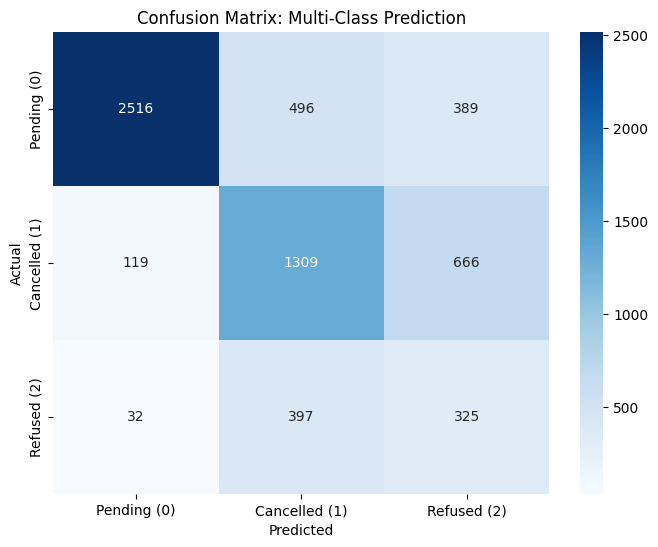

In [26]:
# --- 7. EVALUATION ---
model.eval()
with torch.no_grad():
    y_pred_logits = model(X_test_t)
    # Get the class index with the highest score
    y_pred_classes = torch.argmax(y_pred_logits, dim=1).numpy()

print("\n=== CLASSIFICATION REPORT ===")
target_names = ['Pending (0)', 'Cancelled (1)', 'Refused (2)']
print(classification_report(y_test, y_pred_classes, target_names=target_names))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix: Multi-Class Prediction")
plt.show()